# CUDA NIFTY Gridder (CNG) tests

Results from CUDA NIFTY gridder benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Benchmarks

By default following benchmarks are executed:

- invert test
- predict test

Each benchmark runs for a given image size with varying number of frequency channels provided in `min_chans` and `max_chans` arguments in the test. The metric of interest is elapsed time in sec.

All benchmarks are run for range of number of channels that can be configured at runtime.

## Results of benchmarks

The plots show elapsed times for invert and predict tests for different number of channels. Number of channels are shown as number of visibilities in the plots. For instance, if 1 channel has `nvis` visibilityes, 16 channels will have `16nvis` visibilities. Results are for the most-recent test on each system/partition/environment combination.

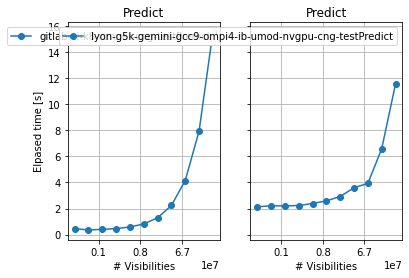

In [4]:
test='CngTest'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=[], test=test, last=True)
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    nsystems = perf_records.groupby(['sysname', 'partition', 'environ']).ngroups
    for perf_name, perf_pat in [('Invert', 'invert'),
                                ('Predict', 'predict')]:
        fig, axes = plt.subplots(nrows=1, ncols=nsystems, sharey=True)
        if nsystems == 1:
            axes = [axes]
        for iplot, (spe, data) in enumerate(
            perf_records.groupby(['sysname', 'partition', 'environ'])):
            c_df = data.loc[data.perf_var.str.contains(perf_pat), :]
            v_df = data.loc[data.perf_var.str.contains('vis'), :].set_index(c_df.index)
            c_df['#vis'] = v_df['perf_value']
            c_df['#vis/s'] = c_df['#vis'] / c_df['perf_value']
            c_df.plot(ax=axes[iplot], x='#vis', y='perf_value', style=['o-'],
                      label='-'.join(spe) + perf_name, legend=None)

        for ax in axes:
            ax.set_xticks(c_df['#vis'])
            ax.set_xticklabels(c_df['#vis'])
            ax.set_title(perf_name)
            ax.set_xlabel('# Visibilities')
            ax.set_ylabel('Elpased time [s]')
            ax.set_xscale('log', base=2)
            if 'lat' in perf_name:
                ax.set_yscale('log', base=10)
            ax.xaxis.set_major_formatter(ScalarFormatter())
            handles, labels = ax.get_legend_handles_labels()
            ax.grid(True, which='both')
            ax.legend()

## Performance History

The plot shows the time taken for invert step using one frequency channel for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

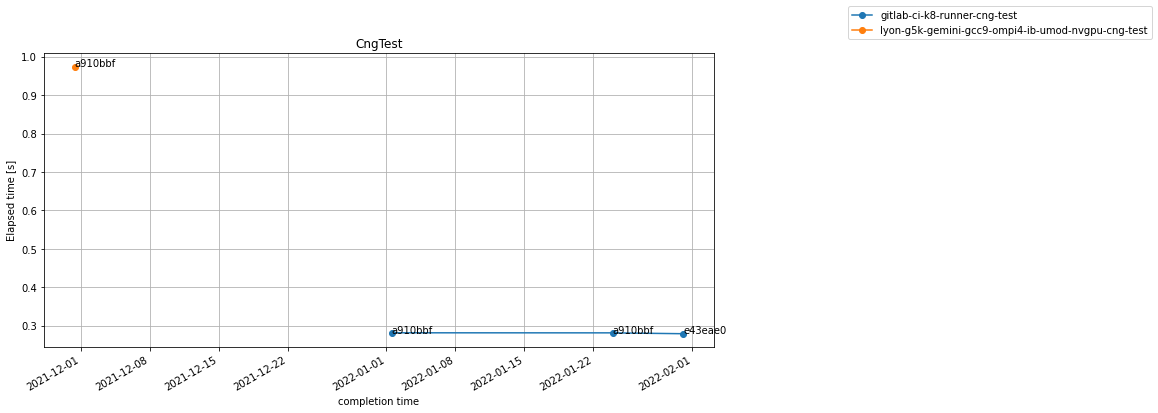

In [5]:
test='CngTest'
nchans = 1
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        # filter to only Gflops records (might have others)
        data = data.loc[data['perf_var'] == f'invert_{nchans}']
        data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

        # annotate points with git_ref:
        for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
            if not pd.isnull(ref):
                ax.annotate(ref[:7], (x, y))
    ax.set_title(test)
    ax.set_xlabel('completion time')
    ax.set_ylabel('Elapsed time [s]')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')